In [43]:
import pandas as pd 

import numpy as np 
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandas.api import types

from linearmodels import PanelOLS


In [44]:
data = pd.read_csv("src/did_training_productivity.csv", index_col = 0)
data["period"] -= 13

Estimate the dynamic specification with $K$ pretreatment leads:

$$Y_{it} = \alpha_i + \delta_t + \sum_{\tau=-K}^{-1} \delta_{\tau} W_i + \epsilon_{it}$$

In [45]:
reg_data = data[["treat_group", "period", "productivity", "log_productivity"]].reset_index().copy()

for i in range(-12,0):
    reg_data[f"time({i})"] = 0
    reg_data.loc[(reg_data["treat_group"] == 1)&(reg_data["period"]==i),f"time({i})"] = 1

reg_data = reg_data.set_index(["worker_id", "period"])

In [46]:
y = reg_data["productivity"]

X = reg_data.drop(["productivity", "log_productivity", "treat_group"], axis = 1)

In [47]:
fe_model = PanelOLS(y, X, entity_effects=True, time_effects=True).fit(cov_type= "clustered", cluster_entity = True)
fe_model

Dep. Variable:,productivity,R-squared:,0.1988
Estimator:,PanelOLS,R-squared (Between):,-0.0535
No. Observations:,48000,R-squared (Within):,0.3362
Date:,"Thu, Apr 17 2025",R-squared (Overall):,-0.0483
Time:,15:28:41,Log-likelihood,-1.81e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,950.64
Entities:,2000,P-value,0.0000
Avg Obs:,24.000,Distribution:,"F(12,45965)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,912.27


Calculate the maximal pre-trend violation:

$$M = \max_{\tau \in [-K, -1]} |\delta_{\tau}|$$

In [48]:
M = np.abs(fe_model.params).max()

M

24.71498779951925

Compute the bias-adjusted treatment effect by subtracting the linear extrapolation of the worst-case violation:

$$\hat{\theta}^{adj} = \hat{\theta} - \lambda M$$

where $\hat{\theta}$ comes from estimation in point 4 above, and $\lambda$ is the post-treatment period length (e.g., $\lambda = 1$ for first post-period).

In [49]:
fe_2way_data = data.reset_index().copy()

fe_2way_data = fe_2way_data.set_index(["worker_id", "period"])

y_2way = fe_2way_data["productivity"]

fe_2way_data["interaction_post"] = fe_2way_data["post"]*fe_2way_data["treat_group"]
X_2way = fe_2way_data["interaction_post"]

In [50]:
fe_model_og = PanelOLS(y_2way, X_2way, entity_effects=True, time_effects=True).fit(cov_type= "clustered", cluster_entity = True)

In [51]:
theta_hat = fe_model_og.params.iloc[0]

In [52]:
theta_hat

22.409441823184064

In [53]:
post_treatment_violations = [i*M for i in range(1,12)]

violations_table = pd.DataFrame(post_treatment_violations)
violations_table.columns = ["worst_case_per_period"]
violations_table["theta_hat"] = theta_hat
violations_table["bias_adjusted_theta"] = theta_hat-post_treatment_violations

In [54]:
violations_table

,worst_case_per_period,theta_hat,bias_adjusted_theta
0,24.714988,22.409442,-2.305546
1,49.429976,22.409442,-27.020534
2,74.144963,22.409442,-51.735522
3,98.859951,22.409442,-76.450509
4,123.574939,22.409442,-101.165497
5,148.289927,22.409442,-125.880485
6,173.004915,22.409442,-150.595473
7,197.719902,22.409442,-175.310461
8,222.434890,22.409442,-200.025448
9,247.149878,22.409442,-224.740436


### Rambachan and Roth

In [76]:
time_index = pd.DataFrame(np.linspace(-12, -1, num = 12, dtype= int))
time_index.columns = ["time"]

params = pd.DataFrame(fe_model.params)
params.index = time_index.index

In [85]:
model = sm.OLS(params, sm.add_constant(time_index)).fit()

pre_trend_slope = model.params["time"]
pre_trend_constant = model.params["const"]

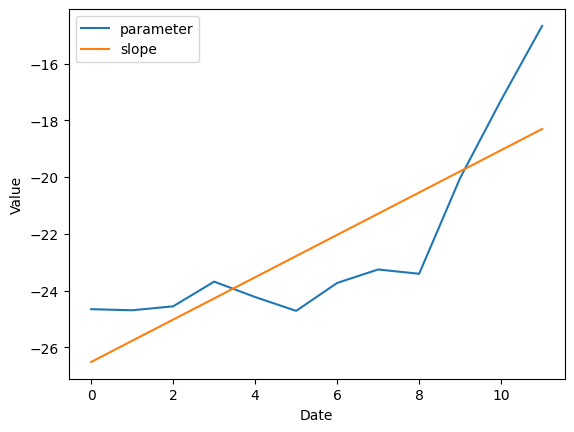

In [93]:
slope_funct = pd.DataFrame([pre_trend_slope * i + pre_trend_constant for i in range(-12, 0)])
slope_funct.columns = ["slope"]
slope_funct.index = params.index

params.plot(ax=plt.gca(), label='params')
slope_funct.plot(ax=plt.gca(), label='slope_funct')


plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [100]:
max_bias_table = pd.DataFrame({
    "0.5": [0.5 * pre_trend_slope],
    "1": [1 * pre_trend_slope],
    "2": [2 * pre_trend_slope]
}).transpose()

max_bias_table.columns = ["Max Bias"]

In [101]:
max_bias_table

,Max Bias
0.5,0.373109
1,0.746218
2,1.492436


In [109]:
# I recalculate the first coefficient, the one we care about
reg_data = data[["treat_group", "period", "productivity", "log_productivity"]].reset_index().copy()

end = 12
start = -end

for i in range(-end,end):
    reg_data[f"time({i})"] = 0
    reg_data.loc[(reg_data["treat_group"] == 1)&(reg_data["period"]==i),f"time({i})"] = 1

reg_data = reg_data.drop(["time(-1)"], axis = 1)
reg_data = reg_data.set_index(["worker_id", "period"])

y = reg_data["productivity"]
y_log = reg_data["log_productivity"]

X = reg_data.drop(["productivity", "log_productivity", "treat_group"], axis = 1)

estudy_model = PanelOLS(y, X, entity_effects=True, time_effects=True).fit(cov_type= "clustered", cluster_entity = True)

In [115]:
coefficient = estudy_model.params["time(1)"]
ci_coefficient = estudy_model.conf_int().loc['time(1)',]

In [120]:
max_bias_table["lowerbound_CI"] = ci_coefficient["lower"]-np.abs(max_bias_table["Max Bias"])
max_bias_table["upperbound_CI"] = ci_coefficient["upper"]+np.abs(max_bias_table["Max Bias"])